In [ ]:
# !pip install torch torchvision torchaudio torch-geometric networkx pandas numpy tqdm newspaper3k lxml[html_clean]
# !pip install -q -U requests tweepy twython scikit-learn matplotlib

In [2]:
# kopiuje repo z fakenewsnet
!git clone https://github.com/KaiDMML/FakeNewsNet.git

Cloning into 'FakeNewsNet'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 759 (delta 8), reused 2 (delta 2), pack-reused 747 (from 3)
Receiving objects: 100% (759/759), 43.99 MiB | 10.37 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [48]:
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import seaborn as sns

In [ ]:
# przed uruchomieniem pamiętać o zmianie w pliku config.json -> zostawić tylko politifact
# pamiętać o dodaniu własmych api key do pliku resources/tweet_keys_file.josn
!python /content/FakeNewsNet/code/main.py

In [ ]:
import shutil

# do zapisania zip -> pobrać dane
shutil.make_archive('/content/politifact_dataset', 'zip', '/content/fakenewsnet_dataset/politifact/fake')
shutil.make_archive('/content/politifact_real', 'zip', '/content/fakenewsnet_dataset/politifact/real')

In [26]:
# Ścieżka do danych
data_path = '/content/FakeNewsNet/dataset/'

# Wczytywanie danych
politifact_fake = pd.read_csv(f'{data_path}politifact_fake.csv')
politifact_real = pd.read_csv(f'{data_path}politifact_real.csv')

# Połączenie danych
df_fake = pd.concat([politifact_fake], ignore_index=True)
df_real = pd.concat([politifact_real], ignore_index=True)

# Dodanie etykiety
df_fake['label'] = 1  # Fake news
df_real['label'] = 0  # Real news

# Łączenie w jeden DataFrame
df = pd.concat([df_fake, df_real], ignore_index=True)

# Wyświetlenie próbek danych
df.head()

,id,news_url,title,tweet_ids,label
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,1
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,1
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,1
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,1
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,1


In [49]:
# Ścieżka do danych
data_path = '/content/fakenewsnet_dataset/politifact/'

# Funkcja wczytująca dane z newscontent.json
def load_news_content(data_path, label):
    news_data = []
    for subfolder in os.listdir(data_path):
        folder_path = os.path.join(data_path, subfolder)
        if os.path.isdir(folder_path):
            news_file = os.path.join(folder_path, 'news content.json')
            if os.path.exists(news_file):
                with open(news_file, 'r') as file:
                    content = json.load(file)
                    news_data.append({
                        'content': content.get('text', ''),
                        'title': content.get('title', ''),
                        'url': content.get('url', ''),
                        'label': label
                    })
    return news_data

# Ładowanie danych dla fake news i real news
fake_news = load_news_content(os.path.join(data_path, 'fake'), 1)  # Fake news
real_news = load_news_content(os.path.join(data_path, 'real'), 0)  # Real news

# Tworzenie DataFrame z połączonych danych
df = pd.DataFrame(fake_news + real_news)

# Wyświetlenie przykładowych danych
df.head()

,content,title,url,label
0,Mike Pence said he didn’t understand why Miche...,Pence: “Michelle Obama Is The Most Vulgar Firs...,https://web.archive.org/web/20161018162637/htt...,1
1,"Kellyanne Conway, counselor to President Trump...",Liberal Women Hate Me Because Of My “Striking ...,https://web.archive.org/web/20170607060712/htt...,1
2,"Puerto Rican born and raised, Colonel Michael ...",SMOKING GUN=> San Juan Teamsters Didn’t Show U...,http://www.thegatewaypundit.com/2017/09/smokin...,1
3,\n\nBREAKING: NFL Fines Pittsburgh Steelers $1...,Head Of NFL Fines Steeler Teammates $1 MILLION...,https://emsnews.wordpress.com/2017/09/26/head-...,1
4,"A woman in Columbus, Ohio, was arrested, charg...",Somali Immigrant Crashes Car Into Ohio Familie...,http://dailyheadlines.net/burka-clad-woman-run...,1


In [50]:
# Inicjalizacja wektoryzatora TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Wybór 5000 najważniejszych cech

# Wektoryzacja treści artykułów
X = vectorizer.fit_transform(df['content']).toarray()  # Przekształcenie na wektory
y = df['label'].values  # Etykiety (0: real, 1: fake)

X.shape, y.shape

((826, 5000), (826,))

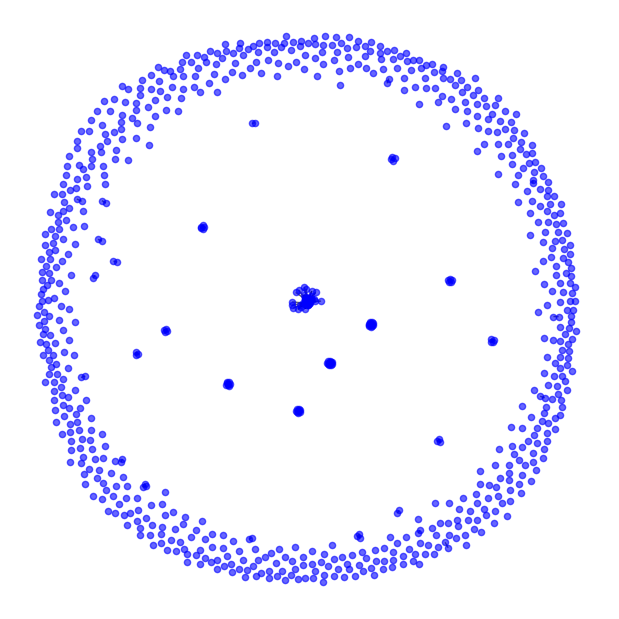

In [51]:
# Obliczanie macierzy podobieństwa między artykułami
similarity_matrix = cosine_similarity(X)

# Tworzymy pusty graf
G = nx.Graph()

# Dodajemy węzły - każdy artykuł jest węzłem w grafie
for i in range(len(df)):
    G.add_node(i, label=df['label'][i])

# Dodajemy krawędzie na podstawie podobieństw (próg 0.7)
threshold = 0.7  # Tylko artykuły o podobieństwie > 0.7 będą połączone krawędzią
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j)

# Wykres grafu
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
nx.draw(G, node_size=20, node_color='blue', with_labels=False, alpha=0.6)
plt.show()

In [52]:
# ==== 3. Przygotowanie danych ====

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# ==== 4. Podział danych ====

num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
test_size = num_nodes - train_size - val_size

train_idx = perm[:train_size]
val_idx = perm[train_size:train_size + val_size]
test_idx = perm[train_size + val_size:]

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True

data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask[val_idx] = True

data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = True

In [53]:
# ==== 5. Definicja modelu ====

class GCN_HPNF(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN_HPNF, self).__init__()
        self.conv1 = GCNConv(in_channels, 128)
        self.conv2 = GCNConv(128, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN_HPNF(in_channels=X.shape[1], out_channels=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [54]:
# ==== 6. Funkcje treningowe ====

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        acc = accuracy_score(data.y[mask].cpu(), pred[mask].cpu())
    return acc, pred

# ==== 7. Trenowanie modelu ====

for epoch in range(1, 51):
    loss = train()
    val_acc, _ = evaluate(data.val_mask)
    print(f"Epoch {epoch}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")

# ==== 8. Ewaluacja na testowym zbiorze ====

test_acc, test_preds = evaluate(data.test_mask)
true_labels = data.y[data.test_mask].cpu().numpy()
pred_labels = test_preds[data.test_mask].cpu().numpy()

print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=["Real", "Fake"]))

Epoch 1, Loss: 0.6898, Val Acc: 0.6485
Epoch 2, Loss: 0.5787, Val Acc: 0.7515
Epoch 3, Loss: 0.4496, Val Acc: 0.7455
Epoch 4, Loss: 0.3337, Val Acc: 0.7515
Epoch 5, Loss: 0.2455, Val Acc: 0.7515
Epoch 6, Loss: 0.1854, Val Acc: 0.8364
Epoch 7, Loss: 0.1473, Val Acc: 0.8424
Epoch 8, Loss: 0.1238, Val Acc: 0.8424
Epoch 9, Loss: 0.1094, Val Acc: 0.8424
Epoch 10, Loss: 0.1010, Val Acc: 0.8364
Epoch 11, Loss: 0.0968, Val Acc: 0.8364
Epoch 12, Loss: 0.0955, Val Acc: 0.8364
Epoch 13, Loss: 0.0960, Val Acc: 0.8303
Epoch 14, Loss: 0.0969, Val Acc: 0.8303
Epoch 15, Loss: 0.0975, Val Acc: 0.8364
Epoch 16, Loss: 0.0971, Val Acc: 0.8424
Epoch 17, Loss: 0.0961, Val Acc: 0.8242
Epoch 18, Loss: 0.0947, Val Acc: 0.8242
Epoch 19, Loss: 0.0936, Val Acc: 0.8242
Epoch 20, Loss: 0.0930, Val Acc: 0.8182
Epoch 21, Loss: 0.0933, Val Acc: 0.8182
Epoch 22, Loss: 0.0940, Val Acc: 0.8182
Epoch 23, Loss: 0.0945, Val Acc: 0.8182
Epoch 24, Loss: 0.0944, Val Acc: 0.8182
Epoch 25, Loss: 0.0938, Val Acc: 0.8364
Epoch 26,

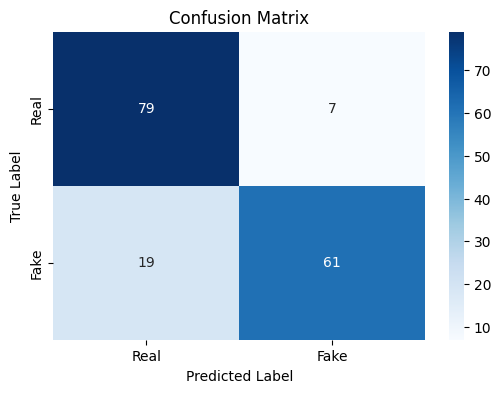

In [55]:
conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [56]:
# zapis do pliku
torch.save(model.state_dict(), 'gcn_hpnf_model.pth')

In [ ]:
# # wczytanie modelu z pliku
# model = GCN_HPNF(in_channels=X.shape[1], out_channels=2)
# model.load_state_dict(torch.load('gcn_hpnf_model.pth'))
# model.eval()